# 4. 이진 분류 (Binary Classification) - KNN
* 머신러닝 알고리즘 : 지도학습 + 비지도학습
* 지도학습 : 훈련을 위한 입력데이터와 정답인 타겟데이터가 필요
* 비지도학습 : 입력데이터만 있음
* 훈련데이터 : 입력데이터 + 타겟데이터
* 특성(Feature) : 입력으로 사용된 길이와 무게
* 여러개의 종류(클래스) 중 하나를 구별해 내는 문제를 분류(Classification)이라고 함
* 2개의 클래스 중 하나를 고르는 문제를 이진 분류(Binary Classification)

## 4-1. 도미와 빙어 분류하기
* k-최근접 이웃 알고리즘을 사용
* 주변에서 가장 가까운 데이터를 보고 다수를 차지하는 데이터를 예측

### 1) 데이터 준비하기

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ori_data = pd.read_csv('data/02_fish/fish.csv')
data = ori_data.copy()
data.head()

,Species,Weight,Vertical_Length,Diagonal_Length,Cross_Length,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


### 2) 데이터 살펴보기

In [28]:
data.shape

(159, 7)

In [29]:
pd.unique(data['Species'])

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

In [30]:
# 입력데이터 만들기
input_df = data[(data.Species=='Bream') | (data.Species=='Smelt')][['Diagonal_Length', 'Weight']]
input_df.columns = ['Length', 'Weight']
input_df.head()

,Length,Weight
0,25.4,242.0
1,26.3,290.0
2,26.5,340.0
3,29.0,363.0
4,29.0,430.0


In [31]:
input_df.shape

(49, 2)

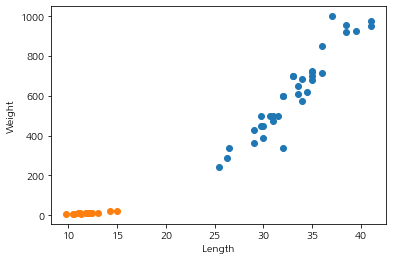

In [76]:
# 산점도 그리기
plt.scatter(input_df[:35].Length, input_df[:35].Weight)  # 도미(Bream)
plt.scatter(input_df[35:].Length, input_df[35:].Weight)  # 빙어(Smelt)
plt.xlabel('Length')
plt.ylabel('Weight')
plt.show()

In [80]:
# 입력데이터는 2차원 배열로 만들기
input_data = input_df.to_numpy()
input_data

array([[  25.4,  242. ],
       [  26.3,  290. ],
       [  26.5,  340. ],
       [  29. ,  363. ],
       [  29. ,  430. ],
       [  29.7,  450. ],
       [  29.7,  500. ],
       [  30. ,  390. ],
       [  30. ,  450. ],
       [  30.7,  500. ],
       [  31. ,  475. ],
       [  31. ,  500. ],
       [  31.5,  500. ],
       [  32. ,  340. ],
       [  32. ,  600. ],
       [  32. ,  600. ],
       [  33. ,  700. ],
       [  33. ,  700. ],
       [  33.5,  610. ],
       [  33.5,  650. ],
       [  34. ,  575. ],
       [  34. ,  685. ],
       [  34.5,  620. ],
       [  35. ,  680. ],
       [  35. ,  700. ],
       [  35. ,  725. ],
       [  35. ,  720. ],
       [  36. ,  714. ],
       [  36. ,  850. ],
       [  37. , 1000. ],
       [  38.5,  920. ],
       [  38.5,  955. ],
       [  39.5,  925. ],
       [  41. ,  975. ],
       [  41. ,  950. ],
       [   9.8,    6.7],
       [  10.5,    7.5],
       [  10.6,    7. ],
       [  11. ,    9.7],
       [  11.2,    9.8],


In [82]:
# 타겟데이터 만들기
target_df = data[(data.Species=='Bream') | (data.Species=='Smelt')][['Species']]
target_df.loc[target_df['Species'] == 'Bream', 'Species'] = 1
target_df.loc[target_df['Species'] == 'Smelt', 'Species'] = 0
target_df

,Species
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [85]:
# 타겟데이터는 1차원 배열로 만들기
target_data = target_df['Species'].to_numpy()
target_data = target_data.astype(np.int)
target_data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

### 3) 모델 학습
* K-최근접 이웃 알고리즘 사용
* 객체 생성
* 모델 훈련 : fit()
* 모델 예측 : predict()
* 모델 평가 : score()

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [86]:
# 객체 생성
kn = KNeighborsClassifier()  # 기본값 5

# 훈련(Training)
kn.fit(input_data, target_data)

KNeighborsClassifier()

In [87]:
kn.predict(input_data)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [88]:
target_data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [38]:
# 새로운 데이터의 정답을 예측
kn.predict([[30, 600]])   # 도미(1)로 예측

array([1])

In [89]:
kn.predict([[1, 1]])

array([0])

In [90]:
# 평가
kn.score(input_data, target_data)

1.0

In [91]:
# Neighbor 갯수 변경
kn49 = KNeighborsClassifier(n_neighbors=49)
kn49.fit(input_data, target_data)

KNeighborsClassifier(n_neighbors=49)

In [93]:
kn49.predict([[1, 1]])

array([1])

In [94]:
kn49.predict(input_data)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [95]:
kn49.score(input_data, target_data)

0.7142857142857143

In [96]:
35/49

0.7142857142857143

## 4-2. 데이터 나누기
* 훈련에 사용한 데이터로 모델을 평가하는 것을 적절하지 않음
* 훈련과 평가를 위한 데이터를 나누기
* 훈련에 사용되는 데이터 : 훈련데이터(training data)
* 평가에 사용하는 데이터 : 평가데이터(test data)

In [46]:
train_input = input_data[:35]
test_input = input_data[35:]
train_input.shape, test_input.shape

((35, 2), (14, 2))

In [47]:
train_target = target_data[:35]
test_target = target_data[35:]
train_target.shape, test_target.shape

((35,), (14,))

In [48]:
kn = kn.fit(train_input, train_target)
kn.score(test_input, test_target)

0.0

In [49]:
kn.predict(train_input)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [50]:
# 무엇이 문제인가?

### 데이터 편향
* 훈련세트와 테스트세트에는 골고루 데이터가 섞여 있어야 함
* 데이터가 골고루 섞여 있지 않으면 샘플링이 한쪽으로 치우쳤다는 의미로 샘플링 편향(sampling bias)이라고 함
* 훈련세트에 도미만 있기 때문에 무조건 도미라고 분류함
* 테스트세트에는 빙어만 있기 때문에 정답을 하나도 맞추지 못함

In [56]:
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트 나누기
train_input, test_input, train_target, test_target = train_test_split(input_data, target_data, random_state=42)
train_input.shape, test_input.shape

((36, 2), (13, 2))

In [57]:
49 * 0.75, 49 * 0.25

(36.75, 12.25)

In [58]:
train_target

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0])

In [59]:
# 도미: 10개, 빙어: 3개 -> 3.3 : 1
test_target

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [105]:
# 전체 데이터 49개 중 도미: 35개, 빙어: 14개 -> 2.5 : 1
35/14

2.5

In [106]:
# stratify : 클래스의 비율에 맞게 데이터를 나눔
train_input, test_input, train_target, test_target = train_test_split(input_data, target_data, stratify=target_data, random_state=42)
train_input.shape, test_input.shape

((36, 2), (13, 2))

In [107]:
# 도미: 9개, 빙어: 4개 -> 2.25 : 1
test_target

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [108]:
9/4

2.25

In [117]:
# 모델 훈련 및 평가
kn = KNeighborsClassifier()   # 다시 모델 생성해주기
kn.fit(train_input, train_target)
kn.score(test_input, test_target)

1.0

In [118]:
# 수상한 도미 한마리
kn.predict([[25, 150]])

array([0])

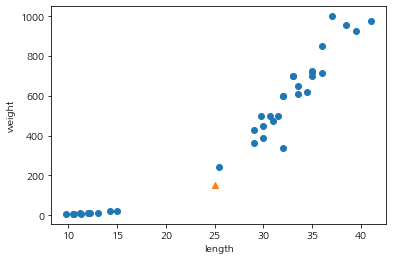

In [119]:
plt.scatter(train_input[:,0], train_input[:,1])
plt.scatter(25, 150, marker='^')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

In [120]:
# 이웃 5개 데이터 살펴보기
distances, indexes = kn.kneighbors([[25, 150]])
distances, indexes

(array([[ 92.00086956, 130.48375378, 130.73859415, 138.32150953,
         138.39320793]]),
 array([[21, 33, 19, 30,  1]], dtype=int64))

In [121]:
train_input[indexes]

array([[[ 25.4, 242. ],
        [ 15. ,  19.9],
        [ 14.3,  19.7],
        [ 13. ,  12.2],
        [ 12.2,  12.2]]])

In [70]:
train_target[indexes]

array([[1, 1, 1, 0, 1]])

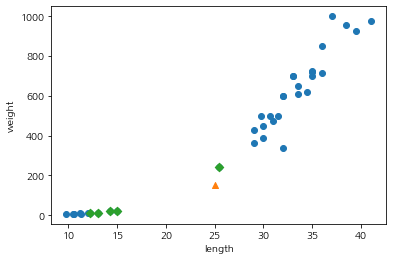

In [122]:
plt.scatter(train_input[:,0], train_input[:,1])
plt.scatter(25, 150, marker='^')
plt.scatter(train_input[indexes, 0], train_input[indexes, 1], marker='D')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

In [123]:
distances

array([[ 92.00086956, 130.48375378, 130.73859415, 138.32150953,
        138.39320793]])

In [ ]:
# 뭐가 문제일까?

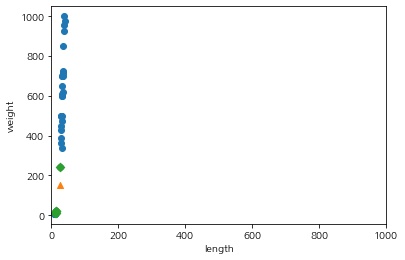

In [124]:
# x, y축을 동일하게 0~1000까지 맞추기
plt.scatter(train_input[:,0], train_input[:,1])
plt.scatter(25, 150, marker='^')
plt.scatter(train_input[indexes, 0], train_input[indexes, 1], marker='D')
plt.xlim((0, 1000))
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

## 4-3. 데이터 전처리 - 표준화
* x축과 Y축의 범위를 동일하게 맞추었더니 모든 데이터가 일직선으로 늘어선 형태가 됨  
* 이 데이터로는 생선의 길이(x축)은 가장 가까운 이웃을 찾는데 크게 영향을 미치지 못함
* 생선의 무게(y축)만 중요한 Feature가 됨
* 두 특성(길이와 무게) 값의 범위가 다름 -> 스케일(scale)이 다르다고도 함
* 예) 방의 넓이는 재는데 세로는 cm로 재고, 가로는 inch로 재면 정사각형인 방도 직사각형처럼 보임
* 데이터를 표현하는 기준이 다르면 알고리즘이 올바르게 예측할 수 없음
* 알고리즘이 거리 기반일 경우는 특히 일정한 기준으로 맞추는 것이 중요 (예: KNN, SVM)

In [125]:
# 표준점수 (Standard Score) 사용하기
# 평균을 빼고 표준편차로 나눔
mean = np.mean(train_input, axis=0)
std = np.std(train_input, axis=0)
mean, std

(array([ 27.29722222, 454.09722222]), array([  9.98244253, 323.29893931]))

In [126]:
train_scaled = (train_input - mean) / std
train_scaled

array([[ 0.24070039,  0.14198246],
       [-1.51237757, -1.36683783],
       [ 0.5712808 ,  0.76060496],
       [-1.60253587, -1.37766373],
       [ 1.22242404,  1.45655528],
       [ 0.17057727, -0.07453542],
       [ 0.87180845,  0.80390854],
       [ 0.87180845,  1.22457184],
       [ 0.37092904,  0.06465464],
       [ 0.77163257,  0.82246721],
       [ 0.97198434,  1.68853872],
       [-1.61255346, -1.3742613 ],
       [ 0.72154463,  0.51315596],
       [-1.53241275, -1.3742613 ],
       [ 0.17057727, -0.28177396],
       [ 0.5712808 ,  0.76060496],
       [ 0.34087627,  0.14198246],
       [ 1.12224816,  1.54934866],
       [ 0.62136874,  0.60594934],
       [-1.30200822, -1.34363949],
       [ 0.42101698,  0.14198246],
       [-0.19005591, -0.65604058],
       [-1.75279969, -1.38384995],
       [ 0.47110492,  0.45129371],
       [-1.68267658, -1.38137546],
       [ 0.62136874,  0.48222484],
       [-1.67265899, -1.38292202],
       [ 0.77163257,  0.76060496],
       [ 0.47110492,

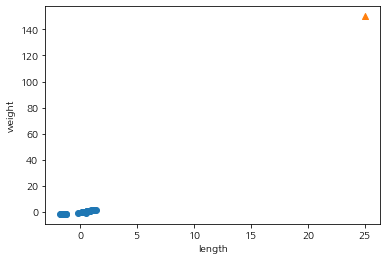

In [127]:
plt.scatter(train_scaled[:,0], train_scaled[:,1])
plt.scatter(25, 150, marker='^')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

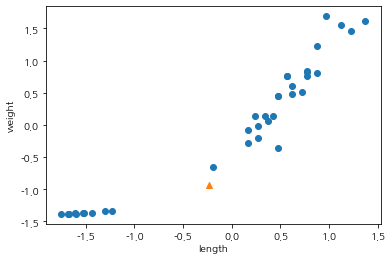

In [130]:
# 샘플데이터도 동일한 비율로 변환해주기
plt.rcParams['axes.unicode_minus'] = False

new = ([25, 150] - mean) / std   # 훈련세트의 mean, std로 변환해야 함
plt.scatter(train_scaled[:,0], train_scaled[:,1])
plt.scatter(new[0], new[1], marker='^')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

In [131]:
kn.fit(train_scaled, train_target)

KNeighborsClassifier()

In [132]:
test_scaled = (test_input - mean) / std
kn.score(test_scaled, test_target)

1.0

In [133]:
kn.predict([new])

array([1])

In [135]:
distances, indexes = kn.kneighbors([new])
distances, indexes

(array([[0.2873737 , 0.7711188 , 0.89552179, 0.91493515, 0.95427626]]),
 array([[21, 14, 34, 32,  5]], dtype=int64))

In [136]:
train_scaled[indexes]

array([[[-0.19005591, -0.65604058],
        [ 0.17057727, -0.28177396],
        [ 0.27075315, -0.19825992],
        [ 0.47110492, -0.35291555],
        [ 0.17057727, -0.07453542]]])

In [137]:
train_target[indexes]

array([[1, 1, 1, 1, 1]])

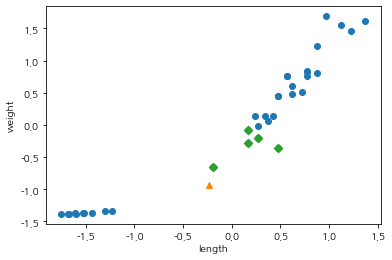

In [138]:
plt.scatter(train_scaled[:,0], train_scaled[:,1])
plt.scatter(new[0], new[1], marker='^')
plt.scatter(train_scaled[indexes, 0], train_scaled[indexes, 1], marker='D')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

In [139]:
from sklearn.preprocessing import StandardScaler

In [140]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

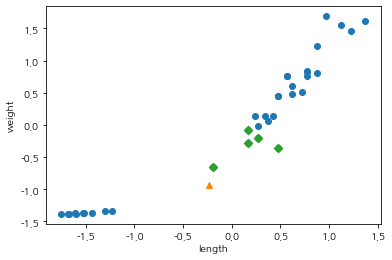

In [141]:
plt.scatter(train_scaled[:,0], train_scaled[:,1])
plt.scatter(new[0], new[1], marker='^')
plt.scatter(train_scaled[indexes, 0], train_scaled[indexes, 1], marker='D')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

In [143]:
kn.fit(train_scaled, train_target)

KNeighborsClassifier()

In [144]:
kn.predict([new])

array([1])

In [145]:
kn.predict(test_scaled)

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [146]:
test_target

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [147]:
kn.score(test_scaled, test_target)

1.0